<a href="https://colab.research.google.com/github/tsubauaaa/LSTM_vs_GRU_generate_Anpanman/blob/master/LSTM_vs_GRU_generate_Anpanman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# 画像データは後で56*56にリサイズする
# 画像の横方向の長さ
img_size = 56
# シーケンスの長さ(画像の縦方向の半分)
seq_length = 28
# 入力層のニューロン数(画像の横方向の長さ)
# LSTM/GRUに入力する特徴量を画像の横方向の長さ(`input_size`) * シーケンスの長さとする
input_size = img_size
# 隠れ層のニューロン層
hidden_size = 256
# 出力数(画像の横方向の長さ)
output_size = img_size
# 1枚の画像に含まれるシーケンスデータの数
data_size_in_img = 56 - seq_length

In [24]:
 # Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# transform作成
transform = transforms.Compose([
    # img_size * img_sizeにリサイズ
    transforms.Resize((56 ,img_size)),
    # 白黒画像にする
    transforms.Grayscale(num_output_channels=1),
    # Tensor型に変換
    transforms.ToTensor()
])


In [26]:
# ImageFolderで指定したフォルダごとにラベルを作成してくれる
train_dataset = datasets.ImageFolder("/content/drive/My Drive/anpanman/train", transform=transform)
val_dataset = datasets.ImageFolder("/content/drive/My Drive/anpanman/val", transform=transform)

In [27]:
print(len(train_dataset))
print(len(val_dataset))

504
10


In [28]:
# batch_sizeは全データ数とするDataLoaderを作成
dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [29]:
# イテレータ化
dataiter = iter(dataloader)
# データ取得
train_imgs, labels = dataiter.next()
# train_imgsのチャンネルの次元を削減 (画像数, channel, H, W) -> (画像数, H, W)
train_imgs = train_imgs.reshape(-1, img_size, img_size)
# シーケンスデータの総数 = train_imgsの数　* 1枚の画像に含まれるシーケンスデータの数
data_size = len(train_imgs) * data_size_in_img

In [30]:
print(len(train_imgs))
print(data_size)
print(train_imgs.size())

504
14112
torch.Size([504, 56, 56])


In [31]:
# 学習データ初期化
input_data = np.zeros((data_size, seq_length, input_size))
# 正解データ初期化
correct_data = np.zeros((data_size, output_size))
# 学習データ数分ループ
for i in range(len(train_imgs)):
    # 1枚の画像に含まれるシーケンスデータの数分ループ
    for j in range(data_size_in_img):
        # data_size_id = i*シーケンス長+j、0からlen(train_imgs)*シーケンス長までが入る
        data_size_id = i*data_size_in_img+j
        # input_dataにtrain_imgsのn_time分のシーケンスデータを入れていく
        input_data[data_size_id] = train_imgs[i, j:j+seq_length]
        # collect_dataにinput_dataの次のデータ(1行分)を入れていく
        correct_data[data_size_id] = train_imgs[i, j+seq_length]
# Tensorに変換
input_data = torch.tensor(input_data, dtype=torch.float)
correct_data = torch.tensor(correct_data, dtype=torch.float)

# データセットの作成
dataset = torch.utils.data.TensorDataset(input_data, correct_data)
# データローダの設定
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [32]:
print(input_data.size())
print(correct_data.size())

torch.Size([14112, 28, 56])
torch.Size([14112, 56])


In [33]:
import torch.nn as nn
import torch.nn.functional as F

# モデルの構築
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        # LSTM層にはinput_sizeにはimg_size、hidden_sizeはハイパーパラメータ、batch_firstは(batch_size, seq_length, input_size)を受け付けたいのでTrueにする
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        # 全結合層のinputはLSTM層のoutput(batch_size, seq_length, hidden_size)と合わせる。outputはimg_size
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # y_rnnは(batch_size, seq_length, hidden_size)となる
        y_rnn, (h,c) = self.rnn(x, None)
        # yにはy_rnnのseq_length方向の最後の値を入れる
        y = self.fc(y_rnn[:, -1, :])
        return y
lstm = LSTM()
lstm.cuda()
print(lstm)

LSTM(
  (rnn): LSTM(56, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=56, bias=True)
)


In [34]:
# モデルの構築
class GRU(nn.Module):
    def __init__(self):
        super().__init__()
        # GRU層にはinput_sizeにはimg_size、hidden_sizeはハイパーパラメータ、batch_firstは(batch_size, seq_length, input_size)を受け付けたいのでTrueにする
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        # 全結合層のinputはGRU層のoutput(batch_size, seq_length, hidden_size)と合わせる。outputはimg_size
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # y_rnnは(batch_size, seq_length, hidden_size)となる。LSTMと違ってcellはない。
        y_rnn, h = self.rnn(x, None)
        # yにはy_rnnのseq_length方向の最後の値を入れる
        y = self.fc(y_rnn[:, -1, :])
        return y
gru = GRU()
gru.cuda()
print(gru)

GRU(
  (rnn): GRU(56, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=56, bias=True)
)


In [35]:
# 評価用データ作成
# 生成し表示する画像の数
disp_size = len(val_dataset)
# batch_size=disp_sizeでデータローダの設定
disp_loader = DataLoader(val_dataset, batch_size=disp_size, shuffle=False)
# イテレータ化
dataiter = iter(disp_loader)
# データ取得
disp_imgs, labels = dataiter.next()
# チャンネル数の次元を削減
disp_imgs = disp_imgs.reshape(-1, img_size, img_size)

In [36]:
# 画像生成用の関数
def generate_images():
    # オリジナルの画像(disp_imgs)の表示
    print('Original:')
    plt.figure(figsize=(20,2))
    # n_disp回ループする
    for i in range(disp_size):
        # subplot(1行, 10列, サブ領域No)
        ax = plt.subplot(1, disp_size, i+1)
        plt.imshow(disp_imgs[i], cmap='Greys_r', vmin=0.0, vmax=1.0)
        # 軸を非表示にする
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    # 下半分をRNNにより生成する
    print('LSTM Gen:')
    # disp_imgsをクローンする
    lstm_gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20,2))
    # n_disp回ループする
    for i in range(disp_size):
        # 1枚の画像に含まれるシーケンスデータの数
        for j in range(data_size_in_img):
            # 予測のための入力値をi番目のgen_imgsのシーケンス長分とする
            # (i, H, W)を(batch_size, seq_length, img_size)にする
            x = lstm_gen_imgs[i, j:j+seq_length].reshape(1, seq_length, img_size)
            # GPU対応
            x = x.cuda()
            # gen_imgsのシーケンス分の次のデータ(1w分)に予測値(1w分)を代入する
            # 次のループでは、代入した予測値を含む入力値でまた予測する
            # net(x)[0]として、batch_size方向を取る(batch_size, img_size) -> (img_size)
            lstm_gen_imgs[i, j+seq_length] = lstm(x)[0]
        # subplot(何行か, 何列か, サブ領域No)
        ax = plt.subplot(1, disp_size, i+1)
        plt.imshow(lstm_gen_imgs[i].detach(), cmap='Greys_r', vmin=0.0, vmax=1.0)
        # 軸を非表示にする
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    print('GRU Gen:')
    gru_gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20,2))
    for i in range(disp_size):
        for j in range(data_size_in_img):
            x = gru_gen_imgs[i, j:j+seq_length].reshape(1, seq_length, img_size)
            x = x.cuda()
            gru_gen_imgs[i, j+seq_length] = gru(x)[0]
        ax = plt.subplot(1, disp_size, i+1)
        plt.imshow(gru_gen_imgs[i].detach(), cmap='Greys_r', vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Epoch: 0, LSTM_Loss_Train: 0.01391304877233985, GRU_Loss_Train: 0.010764593266419509, LSTM Elapsed_Time: 1.6560986042022705, GRU Elapsed_Time: 1.501664638519287
Original:


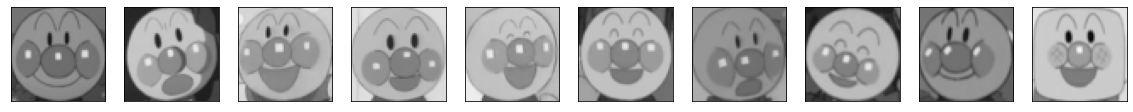

LSTM Gen:


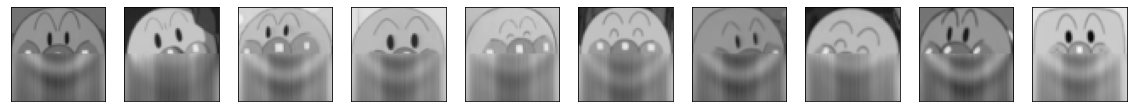

GRU Gen:


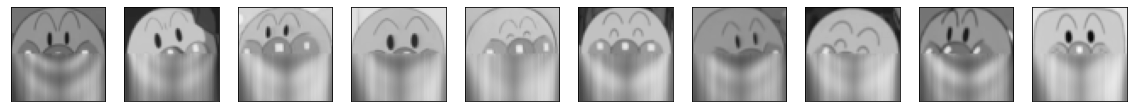

Epoch: 100, LSTM_Loss_Train: 0.0010516532794984223, GRU_Loss_Train: 0.0011553547594299258, LSTM Elapsed_Time: 155.60058736801147, GRU Elapsed_Time: 153.82140946388245
Original:


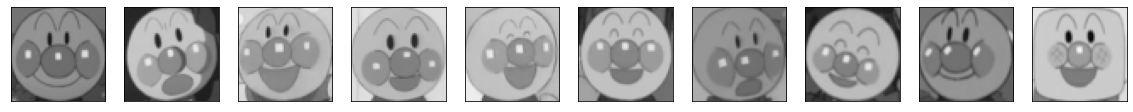

LSTM Gen:


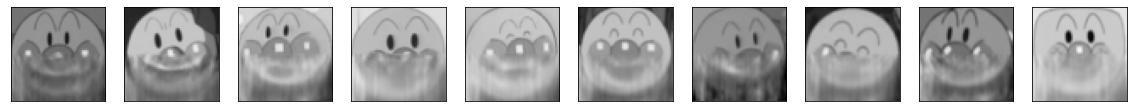

GRU Gen:


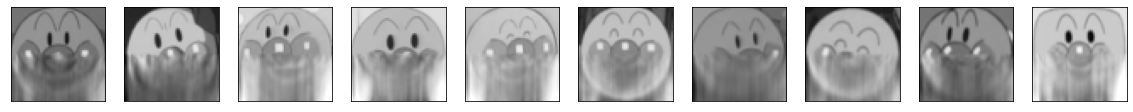

Epoch: 200, LSTM_Loss_Train: 0.000695548227659792, GRU_Loss_Train: 0.0009125221833215008, LSTM Elapsed_Time: 309.71806025505066, GRU Elapsed_Time: 306.54927802085876
Original:


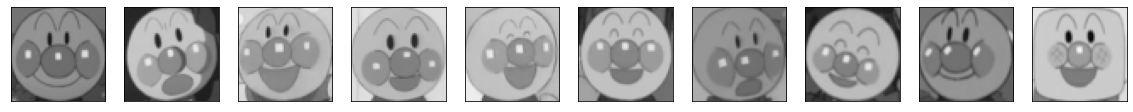

LSTM Gen:


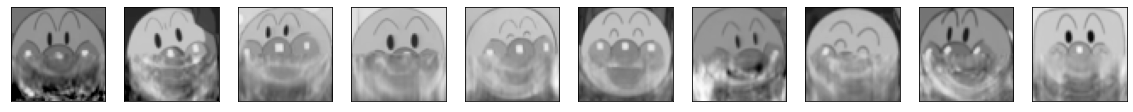

GRU Gen:


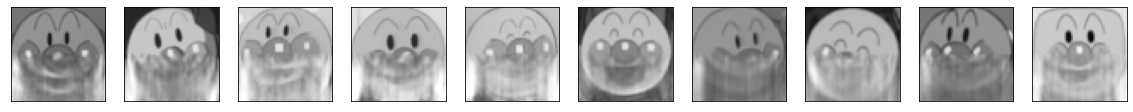

Epoch: 300, LSTM_Loss_Train: 0.0005620583730708605, GRU_Loss_Train: 0.000827734094628401, LSTM Elapsed_Time: 463.6500849723816, GRU Elapsed_Time: 459.05299067497253
Original:


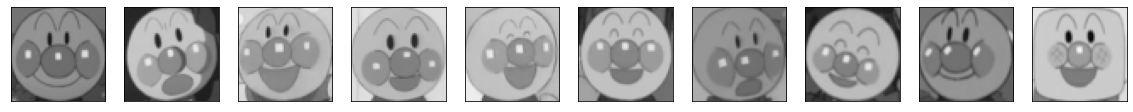

LSTM Gen:


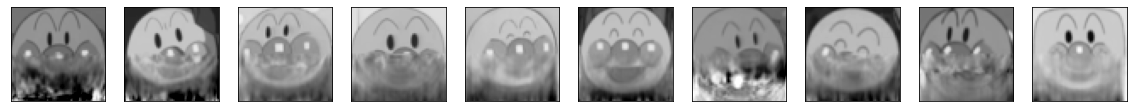

GRU Gen:


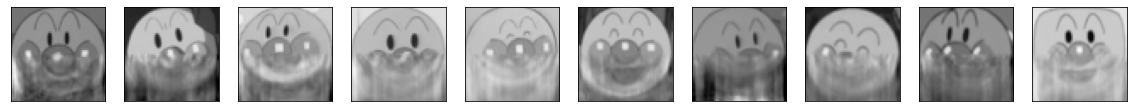

Epoch: 400, LSTM_Loss_Train: 0.0004989382556281654, GRU_Loss_Train: 0.0007556914782168475, LSTM Elapsed_Time: 617.8556108474731, GRU Elapsed_Time: 611.8655271530151
Original:


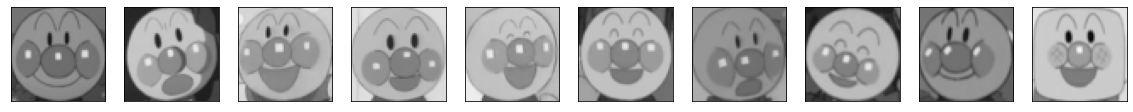

LSTM Gen:


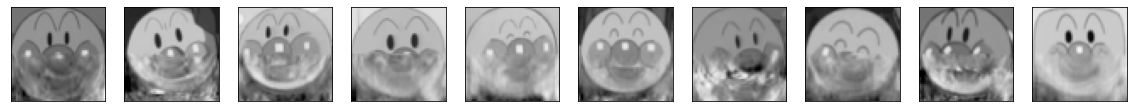

GRU Gen:


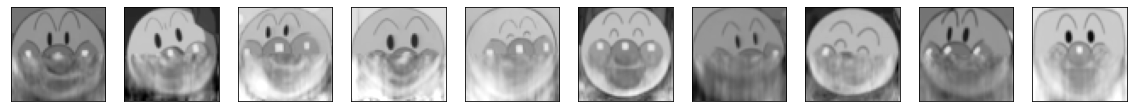

Epoch: 500, LSTM_Loss_Train: 0.00045995664114423956, GRU_Loss_Train: 0.0007278610931872021, LSTM Elapsed_Time: 772.3064270019531, GRU Elapsed_Time: 764.9048600196838
Original:


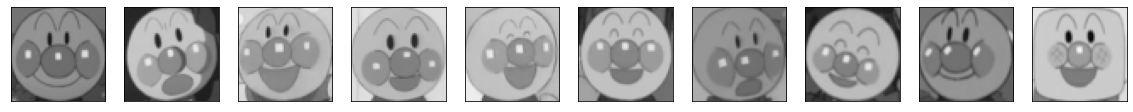

LSTM Gen:


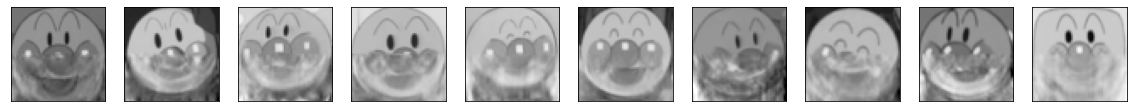

GRU Gen:


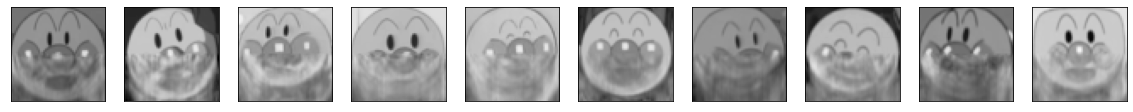

In [37]:
from torch import optim
import time

# 学習
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
lstm_optimizer = optim.Adam(lstm.parameters())
gru_optimizer = optim.Adam(gru.parameters())

# LSTM/GRUの損失を入れる変数を初期化
lstm_record_loss_train = []
gru_record_loss_train = []

# LSTM/GRUの学習時間を入れる変数を初期化
lstm_record_total_time = 0
gru_record_total_time = 0

for i in range(501):
    # ネットワークを学習モードにする
    lstm.train()
    gru.train()
    # epochごとに記録する損失を入れる変数を初期化
    lstm_loss_train = 0
    gru_loss_train = 0

    # LSTMの学習
    lstm_start = time.time()
    for j, (x, t) in enumerate(train_loader):
        x, t = x.cuda(), t.cuda()
        y = lstm(x)
        loss = loss_fnc(y, t)
        lstm_loss_train += loss.item()
        lstm_optimizer.zero_grad()
        loss.backward()
        lstm_optimizer.step()
    lstm_elapsed_time = time.time() - lstm_start

    # GRUの学習
    gru_start = time.time()
    for j, (x, t) in enumerate(train_loader):
        x, t = x.cuda(), t.cuda()
        y = gru(x)
        loss = loss_fnc(y, t)
        gru_loss_train += loss.item()
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()
    gru_elapsed_time = time.time() - gru_start

    # バッチサイズで割って1epochの損失の平均を取る
    lstm_loss_train /= j+1
    lstm_record_loss_train.append(lstm_loss_train)
    gru_loss_train /= j+1
    gru_record_loss_train.append(gru_loss_train)

    # 学習時間の全体時間を計算
    lstm_record_total_time += lstm_elapsed_time
    gru_record_total_time += gru_elapsed_time
    
    # 100回に1回、LSTM/GRUの損失と画像生成結果を表示する
    if i%100 == 0:
        print(f"Epoch: {i}, LSTM_Loss_Train: {lstm_loss_train}, GRU_Loss_Train: {gru_loss_train}, LSTM Elapsed_Time: {lstm_record_total_time}, GRU Elapsed_Time: {gru_record_total_time}")
        generate_images()

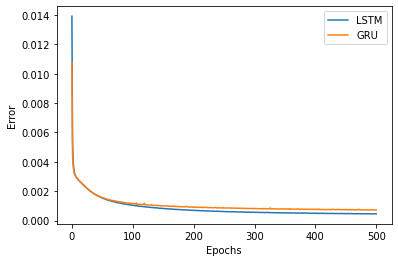

In [38]:
plt.plot(range(len(lstm_record_loss_train)), lstm_record_loss_train, label='LSTM')
plt.plot(range(len(gru_record_loss_train)), gru_record_loss_train, label='GRU')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [39]:
print(f'LSTMとGRUとの経過時間の差: {lstm_record_total_time - gru_record_total_time}')

LSTMとGRUとの経過時間の差: 7.401566982269287
